In [0]:
!pip install cirq

     |████████████████████████████████| 1.2MB 2.8MB/s 
     |████████████████████████████████| 1.2MB 31kB/s 
     |████████████████████████████████| 5.3MB 9.8MB/s 
     |████████████████████████████████| 1.8MB 45.6MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=b68fbc514d1d3c01c0cb000ada755f4b1b84a2023ec08955ed24f5d0ad6839a4
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4


In [0]:
"""Quantum neural network in Cirq."""

# Imports
import cirq
import matplotlib.pyplot as plt
import numpy as np
import sympy

# Class for a ZX gate in Cirq
class ZXGate(cirq.ops.eigen_gate.EigenGate,
             cirq.ops.gate_features.TwoQubitGate):
  """ZXGate with variable weight."""

  def __init__(self, weight=1):
    """Initializes the ZX Gate up to phase.
     Args:
         weight: rotation angle, period 2
    """
    self.weight = weight
    super().__init__(exponent=weight) # Automatically handles weights other than 1

  def _eigen_components(self):
    return [
        (1, np.array([[0.5, 0.5, 0, 0],
                      [ 0.5, 0.5, 0, 0],
                      [0, 0, 0.5, -0.5],
                      [0, 0, -0.5, 0.5]])),
        (-1, np.array([[0.5, -0.5, 0, 0],
                      [ -0.5, 0.5, 0, 0],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0.5, 0.5]]))
    ]

  # This lets the weight be a Symbol. Useful for parameterization.
  def _resolve_parameters_(self, param_resolver):
    return ZXGate(weight=param_resolver.value_of(self.weight))

  # How should the gate look in ASCII diagrams?
  def _circuit_diagram_info_(self, args):
    return cirq.protocols.CircuitDiagramInfo(
           wire_symbols=('Z', 'X'),
           exponent=self.weight)

# Total number of data qubits
INPUT_SIZE = 9

data_qubits = cirq.LineQubit.range(INPUT_SIZE)
readout = cirq.NamedQubit('r')

# Initialize parameters of the circuit
params = {'w': 0}

def ZX_layer():
  """Adds a ZX gate between each data qubit and the readout.
  All gates are given the same sympy.Symbol for a weight."""
  for qubit in data_qubits:
    yield ZXGate(sympy.Symbol('w')).on(qubit, readout)


qnn = cirq.Circuit()
qnn.append(ZX_layer())
qnn.append([cirq.S(readout)**-1, cirq.H(readout)]) # Basis transformation

def readout_expectation(state):
  """Takes in a specification of a state as an array of 0s and 1s
  and returns the expectation value of Z on ther readout qubit.
  Uses the Simulator to calculate the wavefunction exactly."""

  # A convenient representation of the state as an integer
  state_num = int(np.sum(state*2**np.arange(len(state))))

  resolver = cirq.ParamResolver(params)
  simulator = cirq.Simulator()

  # Specify an explicit qubit order so that we know which qubit is the readout
  result = simulator.simulate(qnn, resolver, qubit_order=[readout]+data_qubits,
                              initial_state=state_num)
  wf = result.final_state

  # Becase we specified qubit order, the Z value of the readout is the most
  # significant bit.
  Z_readout = np.append(np.ones(2**INPUT_SIZE), -np.ones(2**INPUT_SIZE))

  # Use np.real to eliminate +0j term
  return np.real(np.sum(wf*wf.conjugate()*Z_readout))

def loss(states, labels):
  loss=0
  for state, label in zip(states,labels):
    loss += 1 - label*readout_expectation(state)
  return loss/(2*len(states))

def classification_error(states, labels):
  error=0
  for state,label in zip(states,labels):
    error += 1 - label*np.sign(readout_expectation(state))
  return error/(2*len(states))

def make_batch():
  """Generates a set of labels, then uses those labels to generate inputs.
  label = -1 corresponds to majority 0 in the sate, label = +1 corresponds to
  majority 1.
  """
  np.random.seed(0) # For consistency in demo
  labels = (-1)**np.random.choice(2, size=100) # Smaller batch sizes will speed up computation
  states = []
  for label in labels:
    states.append(np.random.choice(2, size=INPUT_SIZE, p=[0.5-label*0.2,0.5+label*0.2]))
  return states, labels

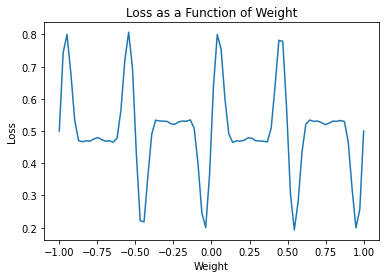

In [0]:
states, labels = make_batch()

linspace = np.linspace(start=-1, stop=1, num=80)
train_losses = []
error_rates = []

for p in linspace:
  params = {'w': p}
  train_losses.append(loss(states, labels))
  error_rates.append(classification_error(states, labels))

plt.plot(linspace, train_losses)
plt.xlabel('Weight')
plt.ylabel('Loss')
plt.title('Loss as a Function of Weight')
plt.show()